# DOGE COIN SVC MODEL

In [111]:
import pandas as pd
import yfinance as yf
import numpy as np 
from pandas.tseries.offsets import DateOffset
from sklearn.preprocessing import StandardScaler
from sklearn import svm
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression

In [112]:
doge_data = yf.download('doge-USD', start='2017-01-01', end='2022-01-01')
doge_df = pd.DataFrame(doge_data)
doge_df.head()

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2017-11-09,0.001207,0.001415,0.001181,0.001415,0.001415,6259550
2017-11-10,0.001421,0.001431,0.001125,0.001163,0.001163,4246520
2017-11-11,0.001146,0.001257,0.001141,0.001201,0.001201,2231080
2017-11-12,0.001189,0.001210,0.001002,0.001038,0.001038,3288960
2017-11-13,0.001046,0.001212,0.001019,0.001211,0.001211,2481270


In [116]:
doge_df['actual_returns'] = doge_df['Close'].pct_change()
doge_df.dropna()
display(doge_df.tail())

,Open,High,Low,Close,Adj Close,Volume,actual_returns,sma_fast,sma_slow
Date,,,,,,,,,
2021-12-28,0.187847,0.187885,0.172738,0.174117,0.174117,954075337,-0.072390,0.182250,0.175263
2021-12-29,0.174095,0.177339,0.166760,0.167765,0.167765,823628336,-0.036481,0.181824,0.174721
2021-12-30,0.168137,0.175771,0.165381,0.171313,0.171313,599236772,0.021149,0.181586,0.174808
2021-12-31,0.171317,0.175294,0.167307,0.170496,0.170496,644416694,-0.004769,0.179837,0.175098
2022-01-01,0.170510,0.173423,0.170353,0.173035,0.173035,371336089,0.014892,0.178139,0.175289


In [117]:
#short Window
short_window = 8
doge_df['sma_fast'] = doge_df['Close'].rolling(window=short_window).mean().dropna()

# long Window
long_window = 21
doge_df['sma_slow'] = doge_df['Close'].rolling(window=long_window).mean().dropna()

doge_df = doge_df.dropna()
doge_df.head()

,Open,High,Low,Close,Adj Close,Volume,actual_returns,sma_fast,sma_slow
Date,,,,,,,,,
2017-12-19,0.006402,0.006693,0.005476,0.005666,0.005666,38885700,-0.119229,0.004781,0.003333
2017-12-20,0.005619,0.007067,0.004892,0.006661,0.006661,67820000,0.175609,0.005201,0.003551
2017-12-21,0.006733,0.008768,0.006583,0.007425,0.007425,159154000,0.114697,0.005697,0.003806
2017-12-22,0.007386,0.007625,0.004742,0.006054,0.006054,63693900,-0.184646,0.005990,0.003992
2017-12-23,0.006135,0.008076,0.006110,0.007259,0.007259,70143104,0.199042,0.006427,0.004235


In [118]:
# features set 
X = doge_df[['sma_fast','sma_slow']].copy().dropna()
display(X.tail())

,sma_fast,sma_slow
Date,,
2021-12-28,0.182250,0.175263
2021-12-29,0.181824,0.174721
2021-12-30,0.181586,0.174808
2021-12-31,0.179837,0.175098
2022-01-01,0.178139,0.175289


In [119]:
# target set 
doge_df['signal'] = 0.0

In [120]:
# buy signal
doge_df.loc[(doge_df['actual_returns'] >= 0), 'signal'] = 1

In [121]:
# sell signal
doge_df.loc[(doge_df['actual_returns'] < 0), 'signal'] = -1

In [122]:
y = doge_df['signal'].copy()

In [123]:
train_start = X.index.min()
print(train_start)

2017-12-19 00:00:00


In [124]:
train_end = X.index.min() + DateOffset(years=3)
print(train_end)

2020-12-19 00:00:00


In [125]:
X_train = X.loc[train_start:train_end]
y_train = y.loc[train_start:train_end]
X_train.head()

,sma_fast,sma_slow
Date,,
2017-12-19,0.004781,0.003333
2017-12-20,0.005201,0.003551
2017-12-21,0.005697,0.003806
2017-12-22,0.005990,0.003992
2017-12-23,0.006427,0.004235


In [126]:
X_test = X.loc[train_end:]
y_test = y.loc[train_end:]
X_test.head()

,sma_fast,sma_slow
Date,,
2020-12-19,0.003473,0.003375
2020-12-20,0.003656,0.003431
2020-12-21,0.003847,0.003490
2020-12-22,0.004007,0.003545
2020-12-23,0.004077,0.003564


In [127]:
scaler = StandardScaler()
X_scaler = scaler.fit(X_train)
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

In [128]:
svm_model = svm.SVC()
svm_model = svm_model.fit(X_train_scaled, y_train)
training_signal_predictions = svm_model.predict(X_train_scaled)
training_signal_predictions[:8]

array([1., 1., 1., 1., 1., 1., 1., 1.])

In [129]:
training_report = classification_report(y_train, training_signal_predictions)
print(training_report)

              precision    recall  f1-score   support

        -1.0       0.54      0.66      0.59       562
         1.0       0.54      0.41      0.47       535

    accuracy                           0.54      1097
   macro avg       0.54      0.54      0.53      1097
weighted avg       0.54      0.54      0.53      1097



In [130]:
testing_signal_predictions = svm_model.predict(X_test_scaled)

In [131]:
svm_testing_report = classification_report(y_test, testing_signal_predictions)
print(svm_testing_report)


              precision    recall  f1-score   support

        -1.0       0.30      0.03      0.06       197
         1.0       0.47      0.92      0.62       182

    accuracy                           0.46       379
   macro avg       0.38      0.48      0.34       379
weighted avg       0.38      0.46      0.33       379



In [132]:
predictions_df = pd.DataFrame(index=X_test.index)
predictions_df['predicted_signal'] = testing_signal_predictions
predictions_df['actual_returns'] = doge_df['actual_returns']
predictions_df['trading_algo_returns'] = predictions_df['actual_returns'] * predictions_df['predicted_signal']
predictions_df.tail()

,predicted_signal,actual_returns,trading_algo_returns
Date,,,
2021-12-28,1.0,-0.072390,-0.072390
2021-12-29,1.0,-0.036481,-0.036481
2021-12-30,1.0,0.021149,0.021149
2021-12-31,1.0,-0.004769,-0.004769
2022-01-01,1.0,0.014892,0.014892


<AxesSubplot:xlabel='Date'>

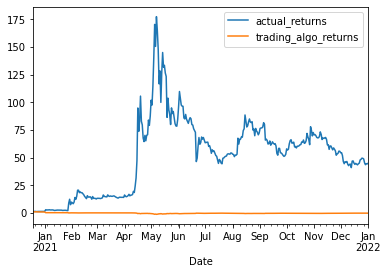

In [133]:
(1 + predictions_df[['actual_returns', 'trading_algo_returns']]).cumprod().plot()

In [134]:
log_reg_model = LogisticRegression()

In [135]:
log_reg_model.fit(X_train_scaled, y_train)

LogisticRegression()

In [136]:
logreg_train_signal_pred = log_reg_model.predict(X_train_scaled)
logreg_train_signal_pred[:10]

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

In [137]:
logreg_train_report = classification_report(y_train, logreg_train_signal_pred)
print(logreg_train_report)

              precision    recall  f1-score   support

        -1.0       0.54      0.70      0.61       562
         1.0       0.54      0.37      0.44       535

    accuracy                           0.54      1097
   macro avg       0.54      0.53      0.52      1097
weighted avg       0.54      0.54      0.52      1097



In [138]:
logreg_test_signal_pred = log_reg_model.predict(X_test_scaled)

In [139]:
logreg_test_report = classification_report(y_test, logreg_test_signal_pred)

In [140]:
print('Logistic Regression Classification Report')
print(logreg_test_report)

Logistic Regression Classification Report
              precision    recall  f1-score   support

        -1.0       0.52      0.89      0.66       197
         1.0       0.51      0.13      0.20       182

    accuracy                           0.52       379
   macro avg       0.52      0.51      0.43       379
weighted avg       0.52      0.52      0.44       379



In [141]:
print('SVM Classification Report')
print(svm_testing_report)

SVM Classification Report
              precision    recall  f1-score   support

        -1.0       0.30      0.03      0.06       197
         1.0       0.47      0.92      0.62       182

    accuracy                           0.46       379
   macro avg       0.38      0.48      0.34       379
weighted avg       0.38      0.46      0.33       379



<AxesSubplot:xlabel='Date'>

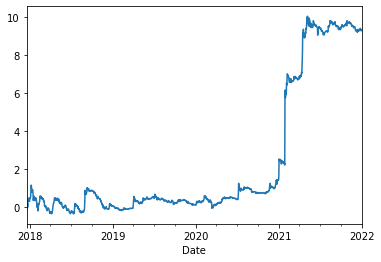

In [143]:
doge_df['actual_returns'].cumsum().plot()